# Fundamentals of Image and Video Processing Innovative Assignment
## Submitted by:
### 18BCE088 - Jyot Makadiya
### 18BCE259 - Shrey Viradiya

In [1]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
! mkdir Ocular
! unzip -q /content/ocular-disease-recognition-odir5k.zip -d Ocular

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
ocular-disease-recognition-odir5k.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘Ocular’: File exists
replace Ocular/ODIR-5K/ODIR-5K/Testing Images/1000_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Importing Libraries

In [2]:
import numpy as np
import cv2
import os 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Enviroment variables

In [3]:
path = "/content/Ocular"
datafr = pd.read_csv(os.path.join(path, "full_df.csv"))
# Image size
ROW = 224
COL = 224

# Images file names
file_names = []

# Loaded data
training_images = []
flags = []

# Processed Features
grayscaled_images = []
inverted_images = []
thresholded_images = []
gray_histogram_of_images = []
RGB_histogram_of_images = []
conny_edged_images = []
laplacian_edged_images = []
x_edged_images = []
y_edged_images = []

threshold_mean = []
threshold_median = []
threshold_std_dev = []

conny_mean = []
conny_median = []
conny_std_dev = []

# Filtering Cataract & Healthy eyes from others

In [4]:
cutter = 0
division = 1 # Increase to decrease number of images to load .. faster outputing for testing
file_names.clear()
flags.clear()
for label, flag, file_name in zip(datafr["Left-Diagnostic Keywords"], datafr["C"], datafr["Left-Fundus"]):
    if(("cataract" in label) and (flag == 1)):
        file_names.append(file_name)
        flags.append(1)
    elif(("normal fundus" in label) and (flag == 0)):
        if(cutter%division == 0):
            file_names.append(file_name)
            flags.append(0)
        cutter = cutter + 1

cutter = 0
for label, flag, file_name in zip(datafr["Right-Diagnostic Keywords"], datafr["C"], datafr["Right-Fundus"]):
    if(("cataract" in label) and (flag == 1)):
        file_names.append(file_name)
        flags.append(1)
    elif(("normal fundus" in label) and (flag == 0)):
        if(cutter%division == 0):
            file_names.append(file_name)
            flags.append(0)
        cutter = cutter + 1

print("Data Length =",len(file_names), "files", len(flags), "flags")

Data Length = 6162 files 6162 flags


# Cataract Ratio

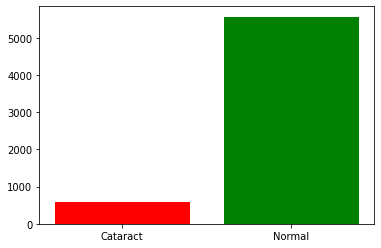

In [5]:
plt.bar([0,1], [len([i for i in flags if i == 1]), len([i for i in flags if i == 0])], color = ['r', 'g'])
plt.xticks([0, 1], ['Cataract', 'Normal'])
plt.show()

# Loading Images

In [6]:
training_images.clear()
for idx, image_name in enumerate(file_names):
    image = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (ROW, COL))
        image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype =cv2.CV_8U)
        training_images.append(image)
    except:
        del flags[idx]

In [7]:
len(training_images)

6078

# Images Sample

(6078, 224, 224, 3)
uint8


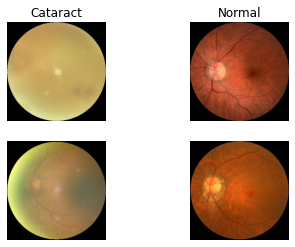

In [8]:
def showSamples(images, gray = False):
    figure, axes = plt.subplots(2, 2)
    axes[0, 0].title.set_text("Cataract")
    axes[0, 1].title.set_text("Normal")
    
    axes[0, 0].axis('off')
    axes[0, 1].axis('off')
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    
    axes[0, 0].imshow(images[0],cmap='gray') if gray else axes[0, 0].imshow(images[0])
    axes[0, 1].imshow(images[2],cmap='gray') if gray else axes[0, 1].imshow(images[2])
    axes[1, 0].imshow(images[17],cmap='gray') if gray else axes[1, 0].imshow(images[17])
    axes[1, 1].imshow(images[12],cmap='gray') if gray else axes[1, 1].imshow(images[12])
    plt.show()

print(np.array(training_images).shape)
print(training_images[1961].dtype)
showSamples(training_images)

# Feature Extraction

## F1 Grayscale

In [9]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray.astype(np.int16)

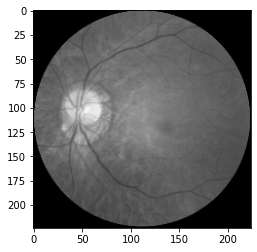

In [10]:
plt.imshow(rgb2gray(training_images[12]), cmap='gray')

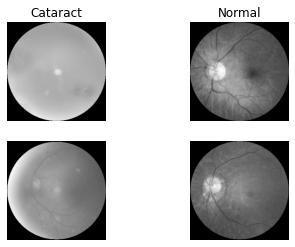

In [11]:
grayscaled_images.clear()
for idx, image in enumerate(training_images):
    gray_image = rgb2gray(image)
    grayscaled_images.append(gray_image)

showSamples(grayscaled_images, True)

## F2 Threshold

In [12]:
def THRESH_TOZERO_INV(gray):
    gray[gray > 127] = 0
    return gray

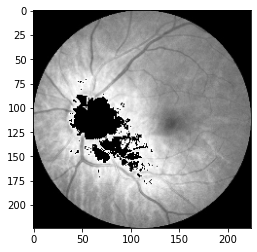

In [13]:
plt.imshow(THRESH_TOZERO_INV(grayscaled_images[2]), cmap='gray')

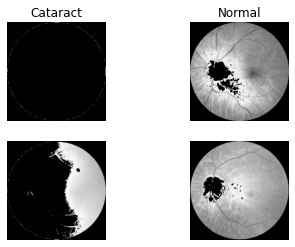

In [14]:
thresholded_images.clear()
for idx, image in enumerate(grayscaled_images):
    image = THRESH_TOZERO_INV(image)
    thresholded_images.append(image)

showSamples(thresholded_images, True)

## F4 Grayscale Histogram

In [15]:
def equalizeHist(image):
    flat = image.flatten()
    hist,bins = np.histogram(flat,256,[0,256])
    cdf = hist.cumsum()
    cdf_m = (cdf - cdf.min())*255/(cdf.max()-cdf.min())
    cdf_m = cdf_m.astype('uint8')
    img_new = cdf_m[flat]
    img_new = np.reshape(img_new, image.shape)
    return img_new

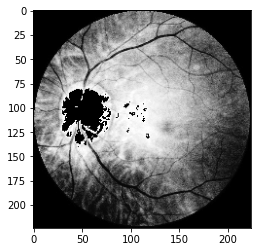

In [16]:
plt.imshow(equalizeHist(grayscaled_images[12]), cmap='gray')

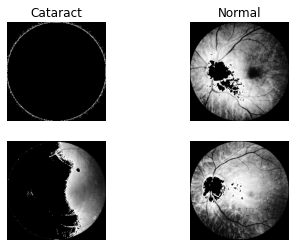

In [17]:
gray_histogram_of_images.clear()
for idx, image in enumerate(grayscaled_images):
    image_histogram = equalizeHist(image)
    gray_histogram_of_images.append(image_histogram)

showSamples(gray_histogram_of_images, True)

## F5 RGB Histogram

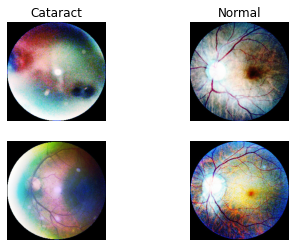

In [18]:
RGB_histogram_of_images.clear()
for idx, image in enumerate(training_images):
    image_histogram_R = equalizeHist(image[:,:,0])
    image_histogram_G = equalizeHist(image[:,:,1])
    image_histogram_B = equalizeHist(image[:,:,2])
    image_histogram = np.dstack((image_histogram_R, image_histogram_G, image_histogram_B))
    RGB_histogram_of_images.append(image_histogram)

showSamples(RGB_histogram_of_images)

## F3 Canny Edge detection

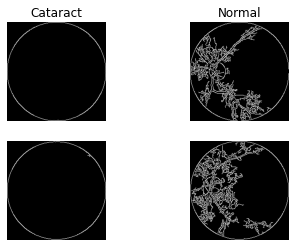

In [19]:
conny_edged_images.clear()
for idx, image in enumerate(training_images):
    image = cv2.Canny(image,30,200)
    conny_edged_images.append(image)

showSamples(conny_edged_images, True)

## F6 X Edges

In [20]:
def SobelX(image):
    filter = np.array([[2,2,4,2,2], [1,1,2,1,1], [0,0,0,0,0],[-1,-1,-2,-1,-1],[-2,-2,-4,-2,-2]])
    return convolve2d(image, filter, mode="same")

def SobelY(image):
    filter = np.array([[2,2,4,2,2], [1,1,2,1,1], [0,0,0,0,0],[-1,-1,-2,-1,-1],[-2,-2,-4,-2,-2]]).T
    return convolve2d(image, filter, mode="same")

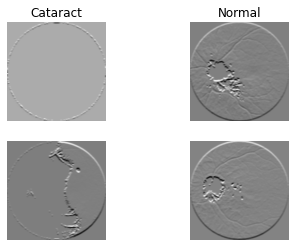

In [21]:
x_edged_images.clear()
for idx, image in enumerate(grayscaled_images):
    sobelx = SobelX(image)
    x_edged_images.append(sobelx)

showSamples(x_edged_images, True)

## F7 Y Edges

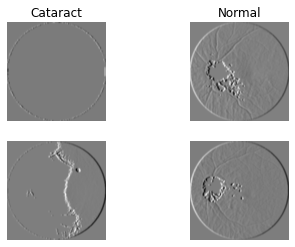

In [22]:
y_edged_images.clear()
for idx, image in enumerate(grayscaled_images):
    sobely = SobelY(image)
    y_edged_images.append(sobely)

showSamples(y_edged_images, True)

## F8 Laplacian Edges

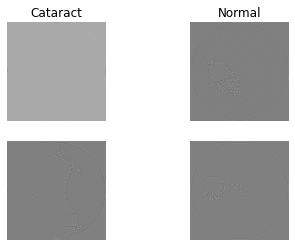

In [23]:
laplacian_edged_images.clear()
for idx, image in enumerate(grayscaled_images):
    lap_image = cv2.Laplacian(image, cv2.CV_64F)
    laplacian_edged_images.append(lap_image)

showSamples(laplacian_edged_images, True)

# Formating the data for Machine Learning

In [24]:
data = []
for i in range(len(training_images)):
    data.append(np.dstack((training_images.pop(0), grayscaled_images.pop(0), inverted_images.pop(0),
                            thresholded_images.pop(0), gray_histogram_of_images.pop(0),
                           RGB_histogram_of_images.pop(0), conny_edged_images.pop(0),
                           laplacian_edged_images.pop(0), x_edged_images.pop(0),
                           y_edged_images.pop(0)
                           )))

IndexError: ignored

In [ ]:
training_features = np.vstack((threshold_mean,threshold_median,threshold_std_dev,conny_mean,conny_median,conny_std_dev)).T

image_train, image_test, flag_train, flag_test = train_test_split(training_features, np.asarray(flags), test_size=0.3, random_state=1)

stdSc = StandardScaler()
image_train = stdSc.fit_transform(image_train)
image_test = stdSc.transform(image_test)

image_train = np.asarray(image_train).astype('float32')
flag_train = np.asarray(flag_train).astype('float32')

image_test = np.asarray(image_test).astype('float32')
flag_test = np.asarray(flag_test).astype('float32')

In [ ]:
image_train.shape

# Building, Training & Testing the NN Model

In [ ]:
classifier = Sequential()

layer_info = Dense(activation='relu', input_dim=6, units=6)
classifier.add(layer_info)

layer_info = Dense(activation='relu', units=4)
classifier.add(layer_info)

layer_info = Dense(activation='sigmoid',units=1)
classifier.add(layer_info)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classifier.fit(image_train, flag_train, batch_size=50, epochs=50)

flag_prediction = classifier.predict(image_test).round()

tn, fp, fn, tp = confusion_matrix(flag_test, flag_prediction).ravel()

print("True Negative =",tn)
print("False Positive =",fp)
print("False Negative =",fn)
print("True Positive =",tp)


print(confusion_matrix(flag_test, flag_prediction))
print(accuracy_score(flag_test, flag_prediction)*100)